In [1]:
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
import napari

In [13]:
from skimage import data
from tifffile import tifffile
from os.path import sep
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import json

In [3]:
#Generate data directory
rootDir= 'For_testing'
dataDir = sep.join([rootDir,'raw','60D05_GCaMP8M_PB_Pilot'])
dataDir_sep = dataDir.split("/")
motionCorrectedDir= sep.join([rootDir,'motionCorrected',sep.join(dataDir_sep[-1:])])

In [4]:
image = tifffile.imread("stack_2.tif")
print(image.shape)

(40, 9, 134, 302)


In [5]:
#import imglyb

In [6]:
#import imagej
#import scyjava
#scyjava.config.add_option('-Xmx6g')
#ij = imagej.init(mode='gui')

In [7]:
#%classpath config resolver scijava.public https://maven.scijava.org/content/groups/public
#%%classpath add mvn
#net.imagej imagej 2.0.0-rc-71
#net.imagej imagej-notebook 0.7.1

In [8]:
viewer = napari.Viewer()
new_layer = viewer.add_image(image)

/opt/anaconda3/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [10]:
viewer.dims.ndisplay = 3

In [11]:
print(image.shape)

(40, 9, 134, 302)


In [14]:
imgStack = xr.DataArray(image,dims = ['volumes [s]', 'planes [µm]', 'xpix [µm]', 'ypix [µm]'])


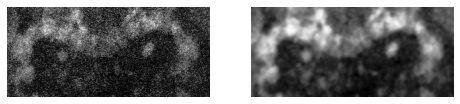

In [15]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume
# Generate reference image
refImg = np.mean(stackMP[0:10,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');


In [36]:
def computeMotionShift(stack, refImage, upsampleFactor, sigmaval = 2, doFilter = False, stdFactor = 2, showShiftFig = True):
    from skimage.registration import phase_cross_correlation

    if len(refImage.shape) == 3:
        print('perform motion correction on a volume')
        refImgFilt = refImage.copy()
        for p in range(stack['planes [µm]'].size):
            refImgFilt[p,:,:] = gaussian_filter(refImage[p,:,:], sigma=sigmaval)
        shift = np.zeros((2, stack['planes [µm]'].size,stack['volumes [s]'].size))
        error = np.zeros((stack['planes [µm]'].size,stack['volumes [s]'].size))
        diffphase = np.zeros((stack['planes [µm]'].size,stack['volumes [s]'].size))
    else:
        print('perform motion correction on a single plane/max projection')
        refImgFilt = gaussian_filter(refImage, sigma=sigmaval)

        shift = np.zeros((2, stack['volumes [s]'].size))
        error = np.zeros(stack['volumes [s]'].size)
        diffphase = np.zeros(stack['volumes [s]'].size)

    # compute shift
    for i in range(stack['volumes [s]'].size):
        if len(refImage.shape) == 3:
            for p in range(stack['planes [µm]'].size):
                shifImg = stack[i,p,:,:]
                shifImgFilt = gaussian_filter(shifImg, sigma=sigmaval)

                # compute shift
                shift[:,p,i], error[p,i], diffphase[p,i] = phase_cross_correlation(refImgFilt[p,:,:].data, shifImgFilt,
                                                                             upsample_factor = upsampleFactor)
        else:
            shifImg = stack[i,:,:]
            shifImgFilt = gaussian_filter(shifImg, sigma=sigmaval)

            # compute shift
            shift[:,i], error[i], diffphase[i] = phase_cross_correlation(refImgFilt, shifImgFilt,
                                                                         upsample_factor = upsampleFactor)
    if showShiftFig:
        if len(refImage.shape) == 3:
            fig, axs = plt.subplots(2,1,figsize=(15,6))
            axlab = ['x','y']
            for i, ax in enumerate(axs):
                ax.plot(shift[i,:].T)
                ax.set_xlabel('frames')
                ax.set_ylabel('image shift for {}'.format(axlab[i]))
        else:
            fig, ax = plt.subplots(1,1,figsize=(15,5))
            ax.plot(shift[0,:])
            ax.plot(shift[1,:])
            ax.set_xlabel('frames')
            ax.set_ylabel('image shift/pixel')

    if doFilter:
        shiftFilt_x = shift[0,:].copy()
        shiftFilt_y = shift[1,:].copy()
        shiftFilt_x[abs(shiftFilt_x) > stdFactor*np.std(shiftFilt_x)] = np.nan
        shiftFilt_y[abs(shiftFilt_y) > stdFactor*np.std(shiftFilt_y)] = np.nan

        allT = np.arange(len(shiftFilt_x))
        shiftFilt_x_interp = np.interp(allT, allT[~np.isnan(shiftFilt_x)], shiftFilt_x[~np.isnan(shiftFilt_x)])
        shiftFilt_y_interp = np.interp(allT, allT[~np.isnan(shiftFilt_y)], shiftFilt_y[~np.isnan(shiftFilt_y)])

        if showShiftFig:
            ax.plot(shiftFilt_x_interp,'b')
            ax.plot(shiftFilt_y_interp,'c')

        return np.vstack((shiftFilt_x_interp,shiftFilt_y_interp))
    else:
        return shift



perform motion correction on a single plane/max projection


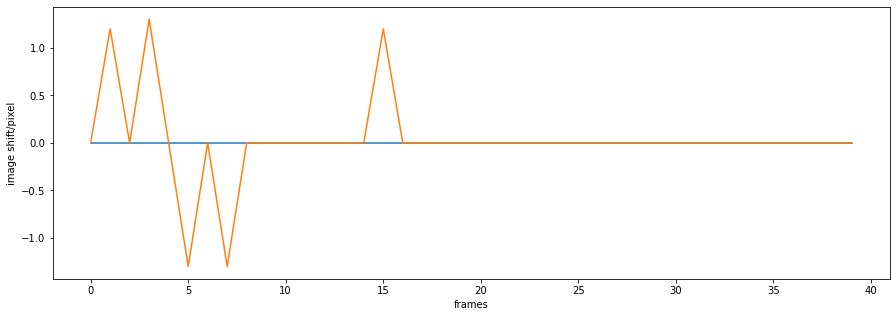

In [37]:
shift = computeMotionShift(stackMP, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)

In [18]:
def motionCorrection(stack, shift):
    from scipy.ndimage import shift as spshift

    #check if shift was calculated for each plane in a volume separately, then check if stack to be aligned is 3d or 4d

    #stack should be an xarray
    stackMC = stack.copy()

    if len(shift.shape) == 3:
        # separate shifts for each plane in a volume
        if len(stack.shape) < 4:
            print("Imaging stack needs to be 4D.")
            return np.nan*stackMC
        for p in range(stack['planes [µm]'].size):
            for i in range(stack['volumes [s]'].size):
                shifImg = stack[i,p,:,:]
                stackMC[i,p,:,:] = spshift(shifImg, shift[:,p,i], order=1,mode='reflect')

    else:
        #one shift per volume per time point
        if len(stack.shape) < 4:
            # motion correction on single plane or max projection
            for i in range(stack['volumes [s]'].size):
                shifImg = stack[i,:,:]
                stackMC[i,:,:] = spshift(shifImg, shift[:,i], order=1,mode='reflect')
        else:
            #motion correction of 4D stack
            for v in range(stack["volumes [s]"].size):  #move one volume at a time
                tmpVol = stack[{"volumes [s]": v}]
                for p in range(tmpVol["planes [µm]"].size):
                    stackMC[v,p,:,:]  = spshift(tmpVol[p,:,:], shift[:,v], order=1,mode='reflect')

    return stackMC

In [20]:
stack4dMC = motionCorrection(imgStack, shift)

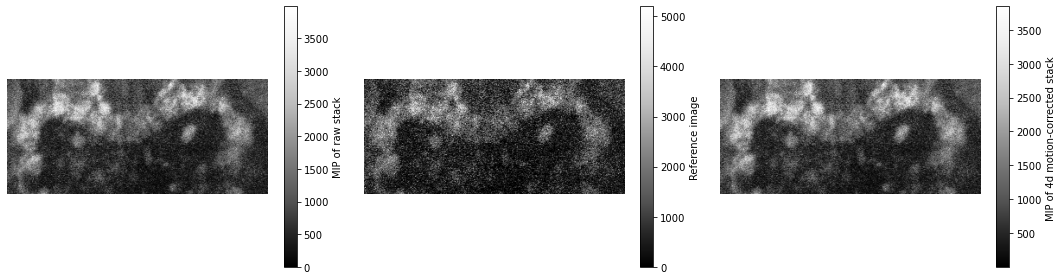

In [21]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
cb = axs[0].imshow(imgStack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

In [23]:
#new_layer = viewer.add_image(image[:,4,:,:])

In [22]:
#viewer.layers.save('my_file.csv')

In [38]:
stack4dMC.shape

(40, 9, 134, 302)

In [25]:
label = tifffile.imread("Labels.tif")
viewer.add_labels(label, name='Labels')

<Labels layer 'Labels' at 0x150a714c0>

In [31]:
shapes = viewer.layers['Labels'].data
shapes = shapes[0,:,:,:]

In [32]:
shapes.shape

(9, 134, 302)

In [60]:
ROI_number = 8
F_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
stack4dMC_numpy = stack4dMC.to_numpy()
for time_point in range(stack4dMC['volumes [s]'].size):
        current_volume = stack4dMC_numpy[time_point,:,:,:]
        for ROI_index in range(1, ROI_number + 1):
            mask = shapes == ROI_index
            F_array[time_point, ROI_index - 1] =current_volume[mask].mean() 

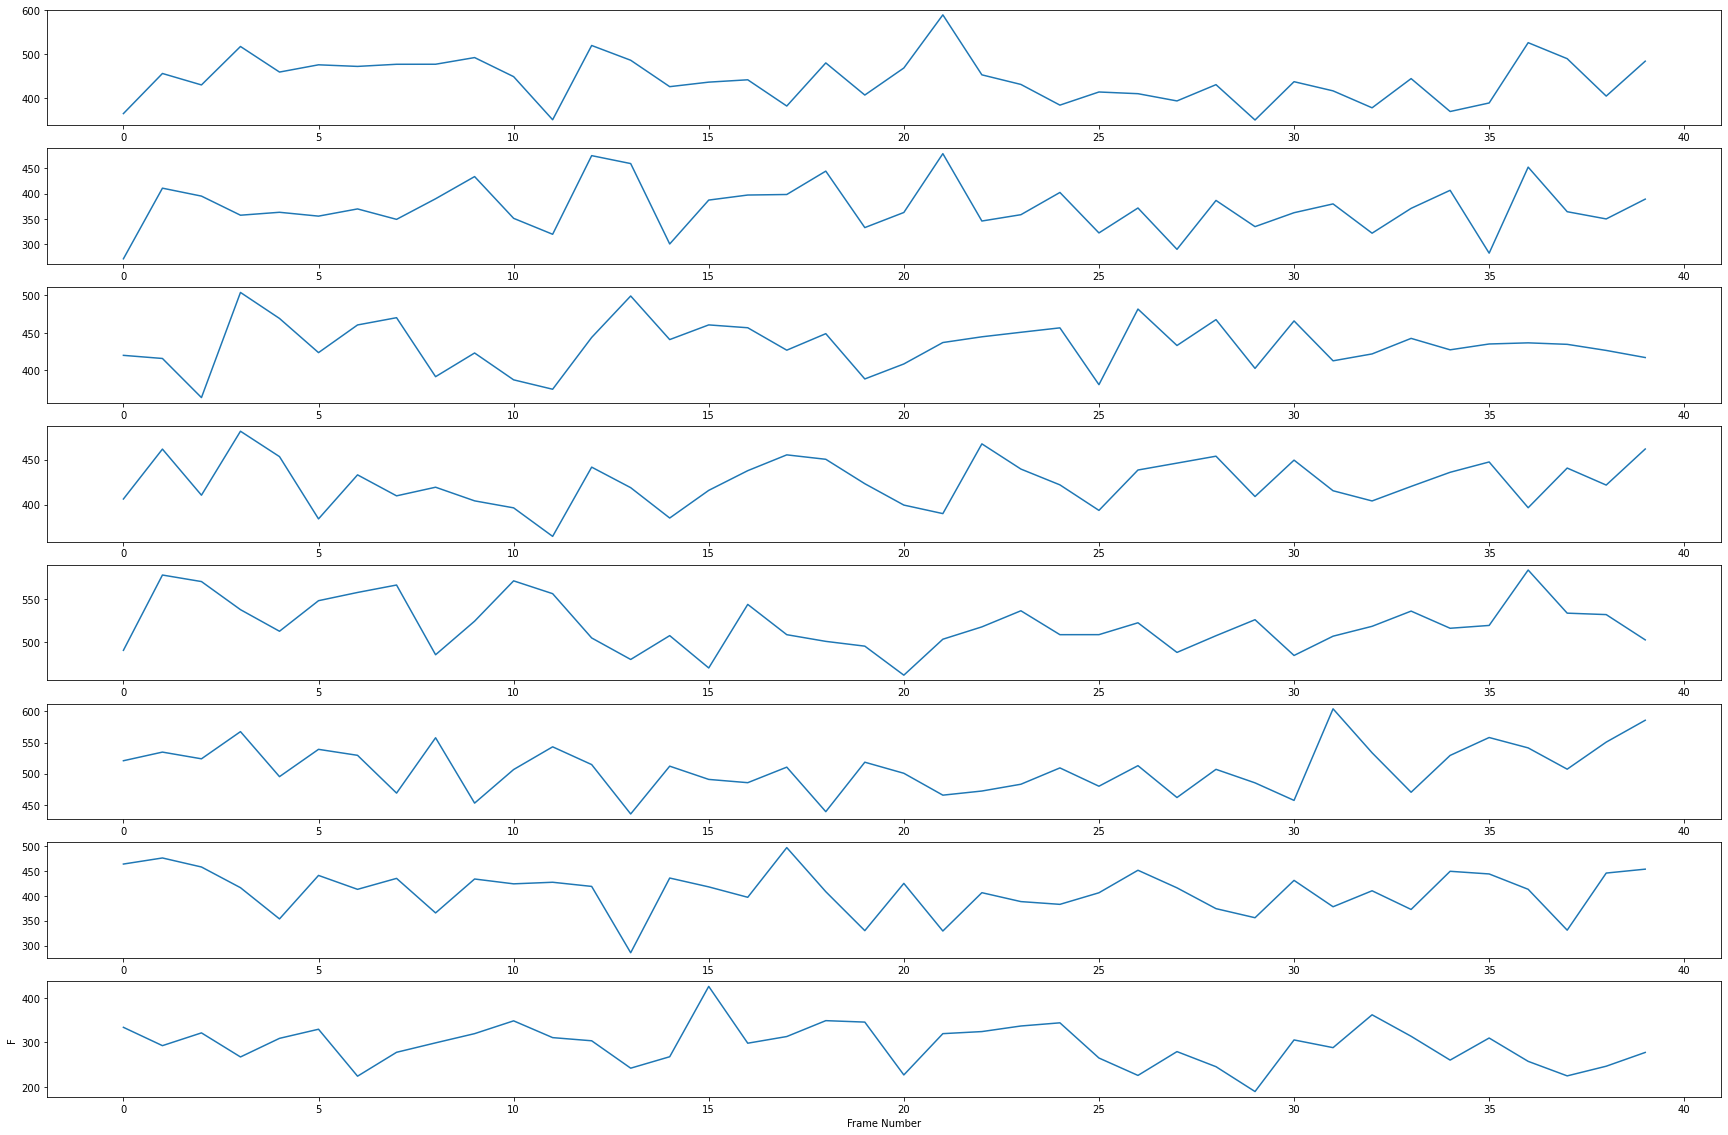

In [61]:
plt.figure(figsize=(30,20))
for i in range(ROI_number):
    plt.subplot(ROI_number, 1, i+1)
    plt.plot(F_array[:,i])
plt.xlabel('Frame Number')
plt.ylabel('F')
fig.tight_layout()

    

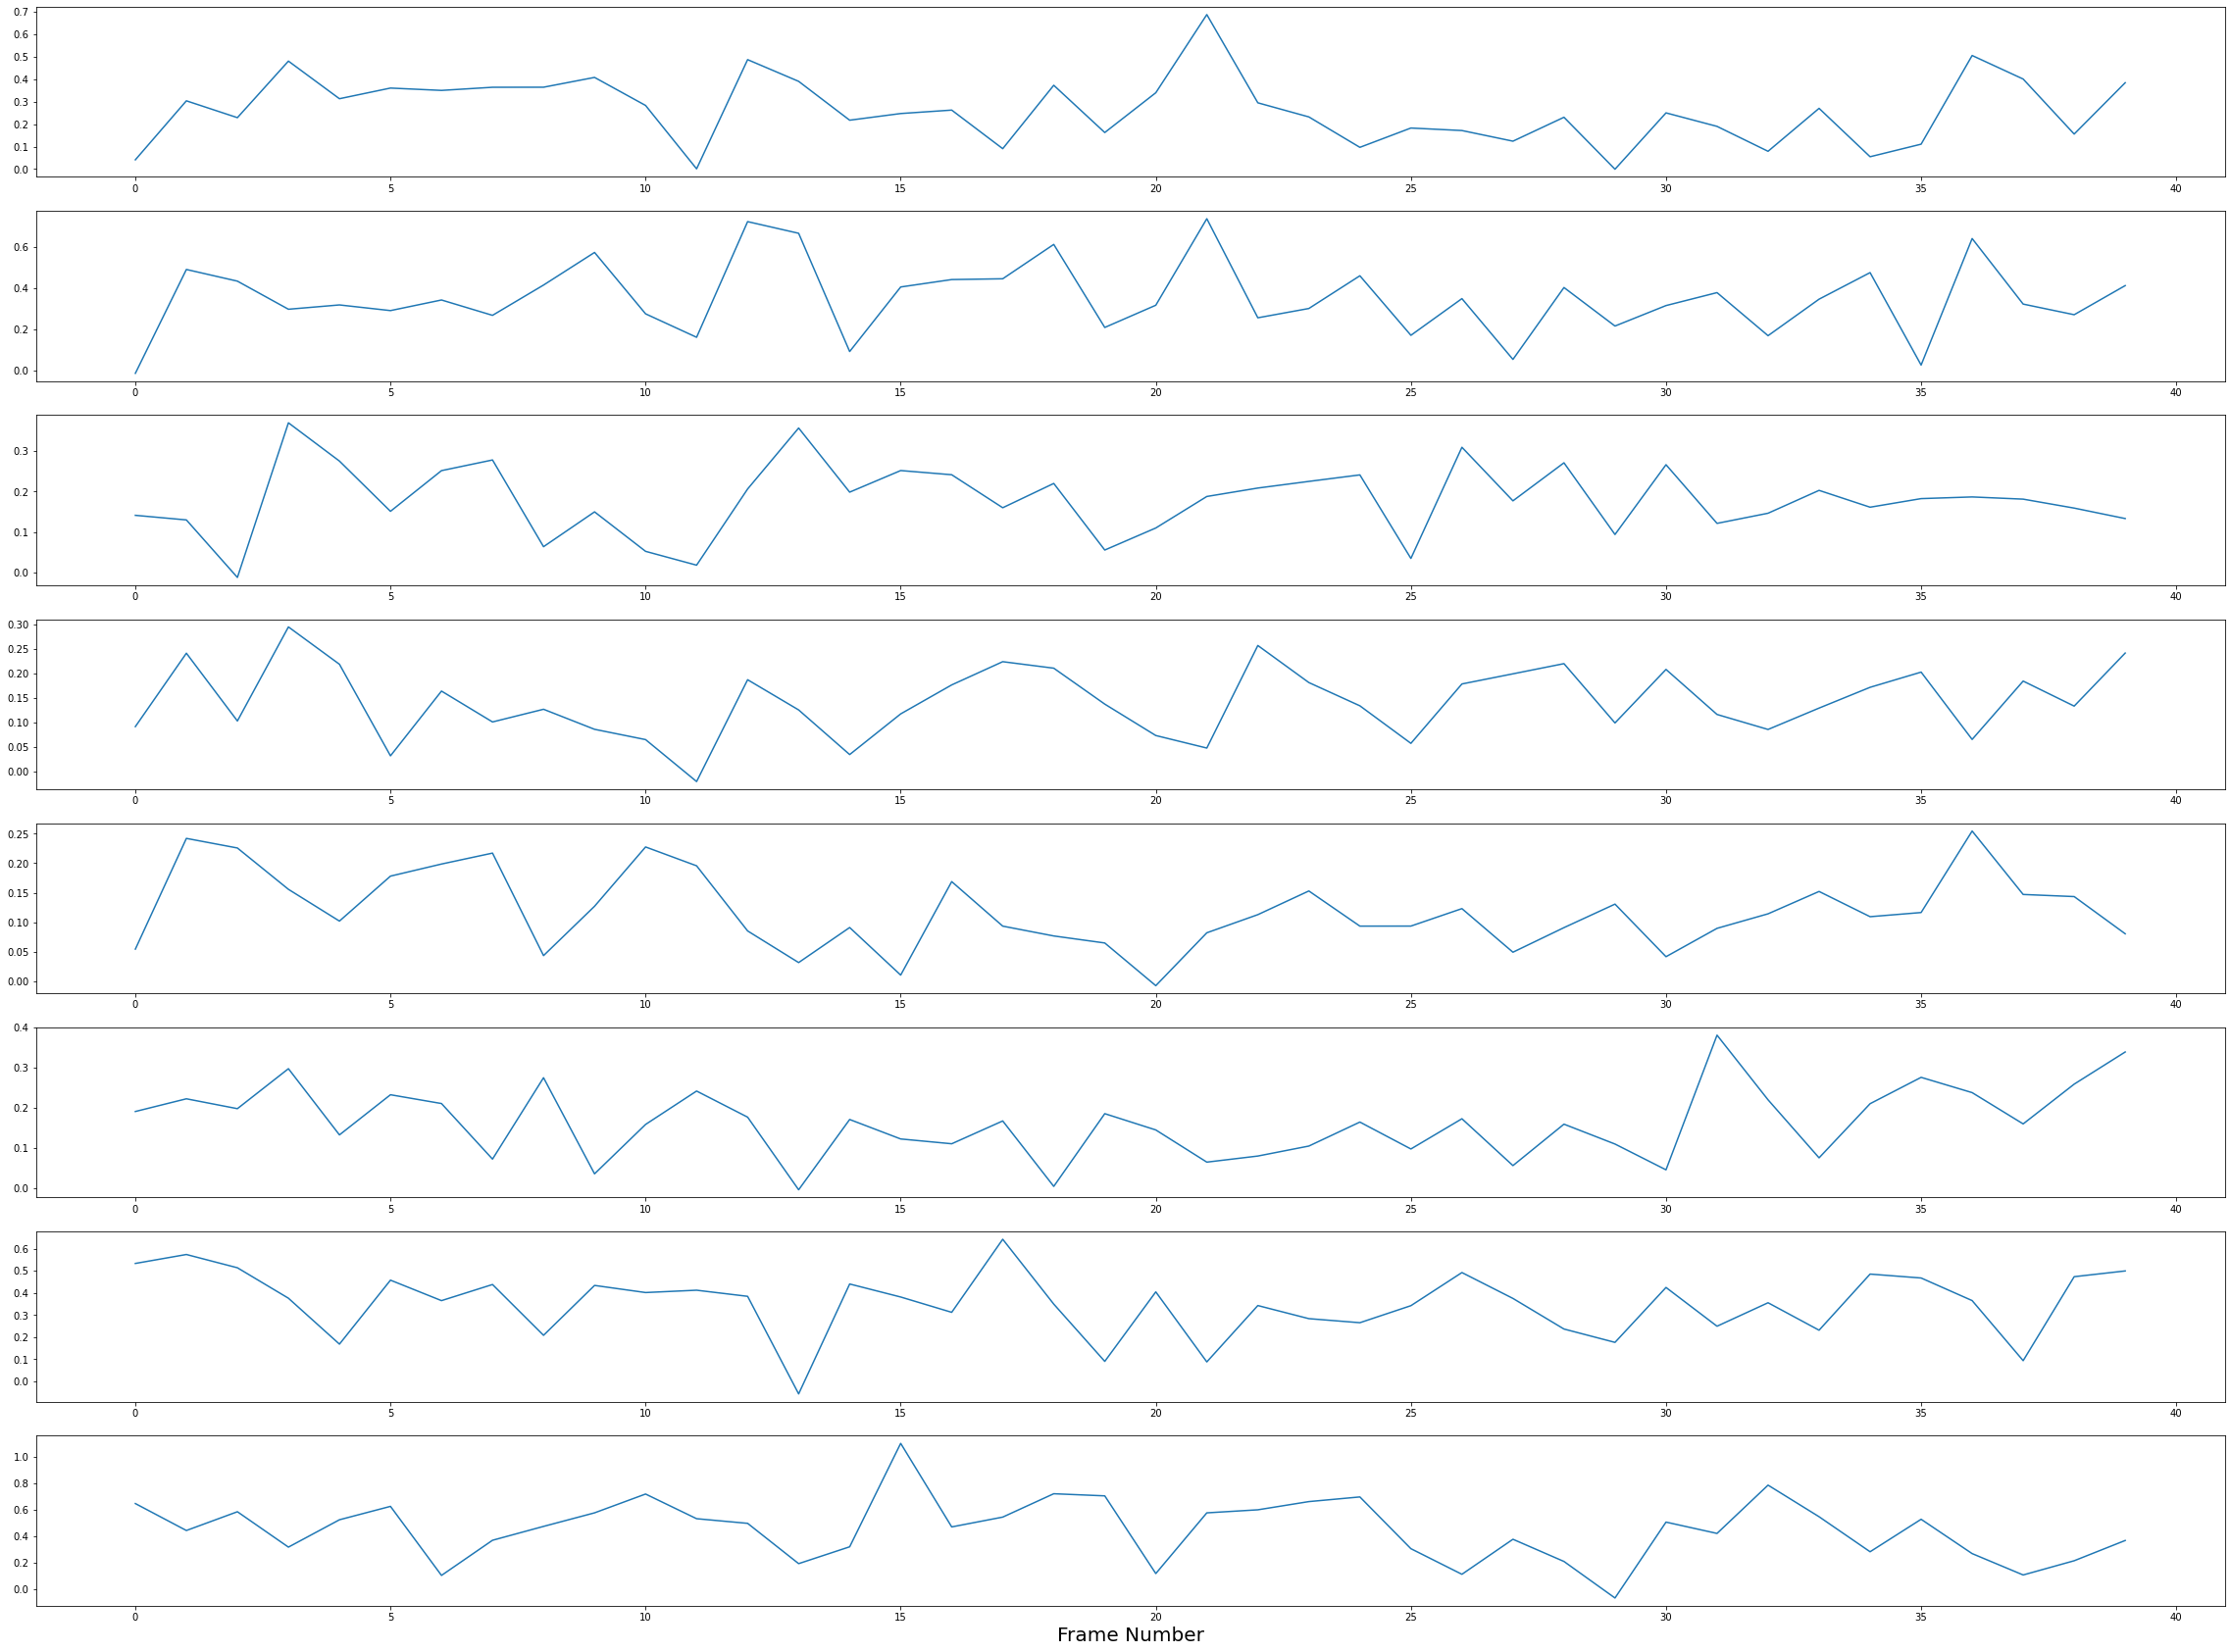

In [80]:
dF_F_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
F_zero = np.quantile(F_array, 0.01, axis = 0)
for F_zero_index in range(ROI_number):
    dF_F_array[:,F_zero_index] = (F_array[:,F_zero_index] - F_zero[F_zero_index])/F_zero[F_zero_index]

plt.figure(figsize=(40,30))
for i in range(ROI_number):
    plt.subplot(ROI_number, 1, i+1)
    plt.plot(dF_F_array[:,i])
plt.xlabel('Frame Number', fontsize=20)
#plt.ylabel('dF/f', fontsize=20)
fig.supylabel('common_y')
fig.tight_layout()

In [73]:
F_zero

array([349.7171028 , 275.65378545, 368.08706706, 372.08059454,
       465.08937627, 437.13189326, 302.6055865 , 202.95251476])

In [170]:
ROI_compressed = np.amax(shapes, axis=0)

In [202]:
test = stack4dMC.to_numpy()

In [206]:
test.shape

(40, 9, 134, 302)